In [1]:
# enable plots in the notebook
import matplotlib.pyplot as plt
# makes our plots prettier
import seaborn
seaborn.set(style='ticks')

#import the audio playback widget
from IPython.display import Audio
from scipy import signal

# useful librairies
import mir_eval
import numpy as np
import scipy
import librosa
import librosa.display
from pydub import AudioSegment 
from ModulationPy import PSKModem, QAMModem

import wave
from scipy.io import wavfile
import contextlib

44100


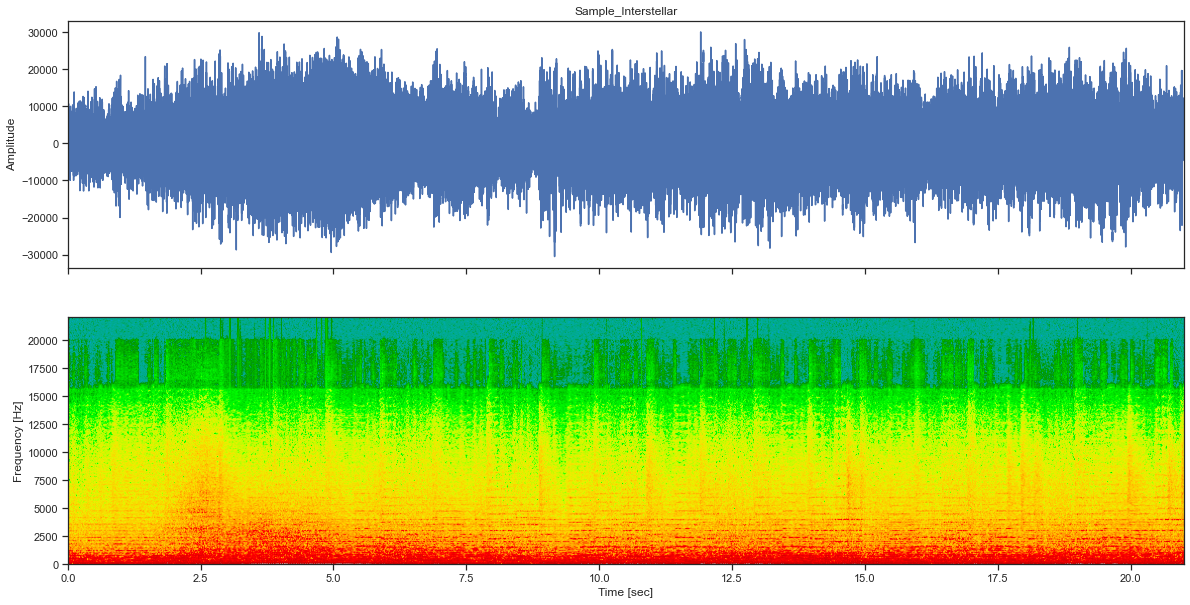

In [2]:
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

def get_start_end_frames(nFrames, sampleRate, tStart=None, tEnd=None):

    if tStart and tStart*sampleRate<nFrames:
        start = tStart*sampleRate
    else:
        start = 0

    if tEnd and tEnd*sampleRate<nFrames and tEnd*sampleRate>start:
        end = tEnd*sampleRate
    else:
        end = nFrames

    return (start,end,end-start)

def extract_audio(fname, tStart=None, tEnd=None):
    with contextlib.closing(wave.open(fname,'rb')) as spf:
        sampleRate = spf.getframerate()
        ampWidth = spf.getsampwidth()
        nChannels = spf.getnchannels()
        nFrames = spf.getnframes()

        startFrame, endFrame, segFrames = get_start_end_frames(nFrames, sampleRate, tStart, tEnd)

        # Extract Raw Audio from multi-channel Wav File
        spf.setpos(startFrame)
        sig = spf.readframes(segFrames)
        spf.close()

        channels = interpret_wav(sig, segFrames, nChannels, ampWidth, True)

        return (channels, nChannels, sampleRate, ampWidth, nFrames)

def convert_to_mono(channels, nChannels, outputType):
    if nChannels == 2:
        samples = np.mean(np.array([channels[0], channels[1]]), axis=0)  # Convert to mono
    else:
        samples = channels[0]

    return samples.astype(outputType)

def plot_specgram(samples, sampleRate, tStart=None, tEnd=None):
    plt.figure(figsize=(20,10))
    plt.specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def plot_audio_samples(title, samples, sampleRate, tStart=None, tEnd=None):
    if not tStart:
        tStart = 0

    if not tEnd or tStart>tEnd:
        tEnd = len(samples)/sampleRate

    f, axarr = plt.subplots(2, sharex=True, figsize=(20,10))
    axarr[0].set_title(title)
    axarr[0].plot(np.linspace(tStart, tEnd, len(samples)), samples)
    axarr[1].specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    #get_specgram(axarr[1], samples, sampleRate, tStart, tEnd)

    axarr[0].set_ylabel('Amplitude')
    axarr[1].set_ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.show()

tStart=0
tEnd=21

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('sample_interstellar.wav', tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)
print(sampleRate)

plot_audio_samples("Sample_Interstellar", samples, sampleRate, tStart, tEnd)

In [3]:
def fir_high_pass(samples, fs, fH, N, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs

    # Compute sinc filter.
    h = np.sinc(2 * fH * (np.arange(N) - (N - 1) / 2.)) 
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Create a high-pass filter from the low-pass filter through spectral inversion.
    h = -h
    h[int((N - 1) / 2)] += 1
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s


def fir_low_pass(samples, fs, fL, N, outputType):
    # Referece: https://fiiir.com

    fL = fL / fs

    # Compute sinc filter.
    h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_band_reject(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fL.
    hlpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hlpf *= np.blackman(NL)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fH.
    hhpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hhpf *= np.blackman(NH)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NH - 1) / 2)] += 1
    # Add both filters.
    if NH >= NL:
        h = hhpf
        h[int((NH - NL) / 2) : int((NH - NL) / 2 + NL)] += hlpf
    else:
        h = hlpf
        h[int((NL - NH) / 2) : int((NL - NH) / 2 + NH)] += hhpf
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def fir_band_pass(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hlpf *= np.blackman(NH)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hhpf *= np.blackman(NL)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NL - 1) / 2)] += 1
    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

In [4]:
from turtle import *
import math


"""
Description :
- Accepte toutes les dimensions de dessin (dans la limite du raisonnable, ne pas dépasser 30x30 pixel).
- PAR EXEMPLE pour dessiner le logo ESIEE, utilisez un fichier txt contenant ceci :

111110011111001000111110011111
110000011000001100110000011000
111110011111001100011110011111
110000000011001100110000011000
111110011111001100111110011111

- Ne pas oublier de fermer turtle avec la commande, bye().

"""


#dessin d'un pixel
def dessinerPixel(x , y):
    fillcolor("black")
    up()
    goto(x,y)
    down()
    begin_fill()
    for i in range(4):
        forward(20)
        left(90)
    end_fill()



#dessine l'image a partir du fichier txt mis en parametre
def dessinerASCII(nomFichier):
    #Variables
    x =-300
    y = 100

    #parametres du stylo
    speed(15)
    delay(0)
    hideturtle()

    fichier = open(nomFichier, "r")
    lignes = fichier.readlines()
    for ligne in lignes:
        for bit in ligne:
            if(bit == "1"):
                dessinerPixel(x , y)
            x+=20
        y-=20
        x=-300
    print("dessin terminé")

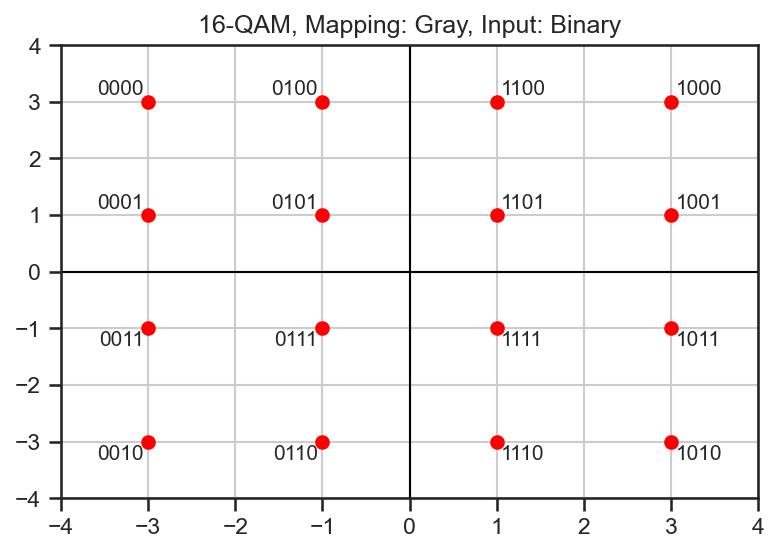

In [5]:
modem = QAMModem(16, 
                 bin_input=True,
                 soft_decision=False,
                 bin_output=True)
modem.plot_const()

In [6]:
def binaire(s):
    ords = (ord(c) for c in s)
    shifts = (7, 6, 5, 4, 3, 2, 1, 0)
    return [(o >> shift) & 1 for o in ords for shift in shifts]

def char(bits):
    chars = []
    for b in range(int(len(bits) / 8)):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)


texte = "L'objectif de ce projet est de créer un système de communication permettant de transmettre de l'information, en l'occurrence une image via la diffusion d'une musique. Afin de parvenir à cet objectif, nous allons utiliser la technique du tatouage du son pour dissimuler les données de notre image dans les hautes fréquences, qui sont inaudibles à l'oreille humaine. Ensuite, à l'aide d’un micro les capter, et après analyse retrouver l'image transmise. Pour ce faire nous disposons de 2 cartes Raspberry pi, un micro et des enceintes."
texte_bin = binaire(texte) #Texte convertit en binaire
texte_binaire = np.array(texte_bin)#Permet de convertir list en array

image = np.array([1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0]) # message d'entrée

msg = np.concatenate((image,texte_binaire)) #msg = image + texte que l'on souhaite transmettre 

#msg = np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0])


print(msg)
#print(texte_binaire[0:10])
print(len(texte))
print(msg.shape)
print(image.shape)
print(texte_binaire.shape)

[1 1 1 ... 1 1 0]
533
(4424,)
(160,)
(4264,)


In [7]:
modulation = modem.modulate(msg) # modulation -> Moduler un tableau de bits en symboles de constellation
print ( " Message modulé : \n " + str (modulation)+ "\n")

 Message modulé : 
 [ 1.-1.j  3.+1.j  1.-1.j ... -3.-1.j -3.-3.j  1.-3.j]



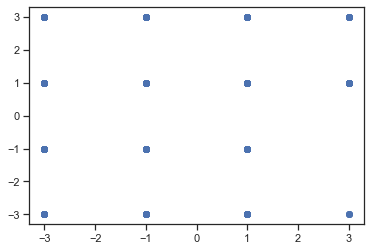

In [8]:
symbols_real = modulation.real
symbols_imag = modulation.imag
plt.scatter(symbols_real,symbols_imag)


In [9]:
#Etape 2 : convolution
import scipy
from commpy.filters import rcosfilter

Tsymbol = 0.0001875*100  # pour correspondre à la durée du sample 

# Débit binaire D = log2(M)/Tsymbol = n/Tsymbol = 21,333 kbps
# augmenter le Tsymbol revient à diminuer le débit binaire D

# B>= (1+ alpha)/Tsymbol --> Tsymbol >= 0.1875 ms

Fsamp = 44100
alpha = 1/2
N = int(5*Tsymbol*Fsamp)
delta_symbols = np.zeros(len(modulation)*int(Tsymbol*Fsamp),dtype =complex)
delta_symbols[::int(Tsymbol*Fsamp)]= modulation

4134


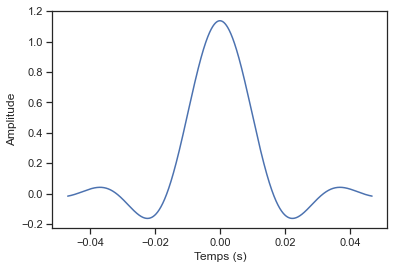

In [10]:
import scipy
from commpy.filters import rrcosfilter
temps, h_rc = rrcosfilter(N, alpha, Tsymbol, Fsamp)
print(len(h_rc))
plt.plot(temps, h_rc)
plt.ylabel('Amplitude')
plt.xlabel('Temps (s)')

plt.show()


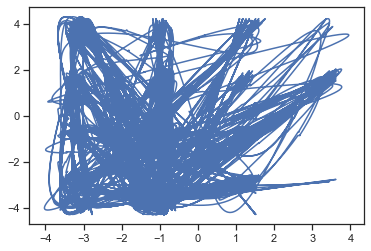

In [11]:
convo = np.convolve(delta_symbols , h_rc, mode="same") 
#print(convo)
plt.figure()
plt.plot(np.real(convo), np.imag(convo))

In [12]:
Fp =16000 
#Fréquence porteuse = milieu de la bande passante


# linspace permet d’obtenir un tableau 1D allant d’une valeur de départ (ordre croissant)
# à une valeur de fin avec un nombre donné d’éléments.

# valeur de départ --> 0
# valeur d'arrivée --> 20.71555555
# nbr valeurs dans tableau --> 913556
t=np.linspace(0 ,np.size(convo)/Fsamp,np.size(convo))
son = np.real(convo*np.exp(2*np.pi*1j*Fp*t))

In [13]:
channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('emetteur_final.wav', tStart, tEnd)
samples2 = convert_to_mono(channels, nChannels, np.int16)

FileNotFoundError: [Errno 2] No such file or directory: 'emetteur_final.wav'

In [ ]:
zu, sigma = 0,0
z = np.random.normal(zu,sigma,np.size(samples2))

son_emetteur_noise = samples2 + z

random_desynch = np.random.randint(1,100)
vzeros = np.zeros(random_desynch,dtype = int)
son_recepteur = np.concatenate([vzeros,son_emetteur_noise])

In [ ]:
lh_samples_filtered = fir_high_pass(son_recepteur, sampleRate, 12500, 461, np.int16)             # First pass
lh_samples_filtered = fir_high_pass(lh_samples_filtered, sampleRate, 12500, 461, np.int16) # Second pass

plot_audio_samples(" Sample_Interstellar - After Filtering 1", lh_samples_filtered, sampleRate, tStart, tEnd)

In [ ]:
Fp = 16000 #Fréquence porteuse
t = np.linspace(0,np.size(son_recepteur)/Fsamp, np.size(son_recepteur)) 

I_reel = 2*son_recepteur*np.cos(2*np.pi*Fp*t) #composante réel en phase 
Q_quadrature = -2*son_recepteur*np.sin(2*np.pi*Fp*t) #composante réel en quadrature


# Vérification son et son2 : normal de ne pas avoir les mêmes valeurs. 
# --> supprimer facteurs 2 de I_reel et Q_quadrature
son2 = I_reel*np.cos(2*np.pi*Fp*t)-Q_quadrature*np.sin(2*np.pi*Fp*t)
#print(son)
#print(son2) 

In [ ]:
I = np.convolve (I_reel, h_rc,'same')
Q = np.convolve (Q_quadrature, h_rc,'same')

In [ ]:
x_t = I+1j*Q #signal complexe en bande de base
print (x_t)
print(convo)
plt.figure()
plt.plot(np.real(x_t),np.imag(x_t))

In [ ]:
sans_synchro = x_t[::int(Tsymbol*Fsamp)]
plt.figure()
plt.scatter(np.real(sans_synchro), np.imag(sans_synchro))

In [ ]:
convo_ss = np.convolve(h_rc,h_rc,'same')
Mconvo_ss =np.max(convo_ss)

div_ss =sans_synchro/Mconvo_ss

plt.figure()
plt.scatter(np.real(div_ss), np.imag(div_ss))

In [ ]:
texte_corr="L'objectif de ce projet est de créer un système de communication permettant de transmettre de l'information, en l'occurrence une image via la diffusion d'une musique."
texte_bin_corr = binaire(texte_corr) #Texte convertit en binaire
texte_binaire_corr = np.array(texte_bin_corr)
msg_test = modem.modulate(texte_binaire_corr)


delta_symbols_corr = np.zeros(len(msg_test)*int(Tsymbol*Fsamp),dtype =complex)
delta_symbols_corr[::int(Tsymbol*Fsamp)]= msg_test

In [ ]:
s_BB_oh = np.convolve(delta_symbols_corr, h_rc, mode="same") 

In [ ]:
correl = scipy.signal.correlate(s_BB_oh,x_t[:np.size(s_BB_oh)])

plt.figure()
plt.plot(np.abs(correl))


In [ ]:
rshift = np.size(s_BB_oh)-np.argmax(np.abs(correl))
print(rshift)

In [ ]:
corr_alpha =[]
A = np.linspace(0,1,1000)
for alpha in A :
    r_BB_coh_oh = x_t[rshift:(np.size(s_BB_oh)+rshift)]*np.exp(2j*np.pi*alpha)
    R = np.corrcoef(np.real(r_BB_coh_oh),np.real(s_BB_oh))
    corr_alpha.append((R[0,1]))
    
ccc = np.argmax(corr_alpha)
print(ccc)

In [ ]:
test = x_t[rshift:]*np.exp(2j*np.pi*A[ccc])
test2 = test[::int(Fsamp*Tsymbol)]

print(test2)
plt.figure()
plt.scatter(np.real(test2),np.imag(test2))

In [ ]:
convo2 = np.convolve(h_rc,h_rc,'same')
Mconvo2 =np.max(convo2)

div =test2/Mconvo2

plt.figure()
plt.scatter(np.real(div), np.imag(div))

In [ ]:
demodulation = modem.demodulate(div) # modulation -> Moduler un tableau de bits en symboles de constellation
print ( " Message modulé : \n " + str (demodulation)+ "\n")

print()
print(len(demodulation))

In [ ]:
def dessinerASCII(nomFichier, nbL):
    """
    fonction qui prend le nom du fichier texte décrivant l'image et le nombre de ligne concerné.
    il dessine ensuite l'image à l'aide de la fonction "dessinerPixel".
    """


    #Variables
    x =-300
    y = 100
    c = 0

    #parametres
    speed(15)
    delay(0)
    hideturtle()

    fichier = open(nomFichier, "r")
    lignes = fichier.readlines()
    
    
    for ligne in lignes:
        c += 1
        for bit in ligne:
            if(bit == "1" and c < nbL + 1):
                dessinerPixel(x , y)
            x+=10
        y-=10
        x=-300
        
    print("dessin terminé")
   
def convDemod(demodulation):
    """
    ENTREE : Prend en parametre le résultat de la démodulation du signal.
    AFFICHAGE : Affiche l'image et la phrase transmise en appelant les fonctions précédentes.
    SORTIE : Enregistre un fichier "resultat.txt" dans le dossier courant contenant l'image, et la phrase en binaire.
    
    """
    #variables :
    h = 0
    l = 0
    
    f = open('resultat.txt', 'w')    
    c=0
    for i in range(16):
        f.write(str(demodulation[i])[0])
        c += 1
        if(c==8):
            f.write("\n")
            c = 0
            
    for i in range(demodulation.size - 16):
        f.write(str(demodulation[i+16])[0])
    f.close()
    
    
    
    f = open('resultat.txt', 'r') 
    lignes = f.readlines()
    
    c = 0
    for ligne in lignes:
        c += 1
        if(c == 1):
            l = ligne
        if(c == 2):
            h = ligne
    
    f.close()
    
    f = open('resultat.txt', 'w') 
    
    l = int(l, base = 2)
    h = int(h, base = 2)
    
    c = 0
    p = 0
    for i in range(demodulation.size - 16):
        c += 1
        f.write(str(demodulation[i+16])[0])
        if(c==l and p<5):
            f.write("\n")
            p += 1
            c = 0
            
    f.close()
     
    dessinerASCII('resultat.txt', h)
    
    fichier = open('resultat.txt', "r")
    lignes = fichier.readlines()
    texte = char(lignes[h])
    print("Phrase interprétée : " + texte)
        
    
    
    """""
    #debug
    print(l)
    print(h)
    print(type(l), type(h))
    """
    
    f.close()

In [ ]:
convDemod(demodulation)

In [ ]:
bye()

In [ ]:
texte_char = char(demodulation) #Convertit du binaire au texte -> Vérification de la conversion en binaire
print(texte_char)